In [ ]:
from neo4j import GraphDatabase
import os
from dotenv import load_dotenv
import networkx as nx
import matplotlib.pyplot as plt


'''NO DESCOMENTEN
NADA POR FA QUE SE
PETATEA PORQUE YA
ESTÁ EN LA BASE!!!!!!'''

load_dotenv()
URI = os.getenv("NEO4J_URI") 
AUTH = (os.getenv("NEO4J_USER"), os.getenv("NEO4J_PASSWORD"))

driver = GraphDatabase.driver(URI, auth=AUTH)

def crear_nodo(query = '', type = '', parametros={}):
    with driver.session() as session:
        if type == 'user':
            query = "MERGE (:USUARIO {idu: $idu, nombre: $nombre})"
        elif type == 'post':
            query = "MERGE (:POST {idp: $idp, contenido: $contenido})"
        elif type == 'comment':
            query = "MERGE (:COMENTARIO {consec: $consec, contenidoCom: $contenidoCom, fechorCom: $fechorCom, likeNotLike: $likeNotLike, fechorAut: $fechorAut})"

        session.execute_write(lambda tx: tx.run(query, **parametros))

def crear_relacion(nodo1, clave1, valor1, relacion, nodo2, clave2, valor2):
    query = f"""
        MATCH (a:{nodo1} {{{clave1}: $valor1}}), (b:{nodo2} {{{clave2}: $valor2}})
        MERGE (a)-[:{relacion}]->(b)
    """
    with driver.session() as session:
        session.execute_write(lambda tx: tx.run(query, valor1=valor1, valor2=valor2))

def actualizar_nodo(nodo, clave, valor, nuevos_valores):
    set_clause = ", ".join([f"{k}: ${k}" for k in nuevos_valores.keys()])
    query = f"""
        MATCH (n:{nodo} {{{clave}: $valor}})
        SET n += {{{set_clause}}}
    """
    with driver.session() as session:
        session.execute_write(lambda tx: tx.run(query, valor=valor, **nuevos_valores))

def eliminar_nodo(nodo, clave, valor):
    query = f"""
        MATCH (n:{nodo} {{{clave}: $valor}})
        DETACH DELETE n
    """
    with driver.session() as session:
        session.execute_write(lambda tx: tx.run(query, valor=valor))

def actualizar_relacion(nodo1, clave1, valor1, relacion, nodo2, clave2, valor2, nuevos_valores):
    set_clause = ", ".join([f"r.{k} = ${k}" for k in nuevos_valores.keys()])
    query = f"""
        MATCH (a:{nodo1} {{{clave1}: $valor1}})-[r:{relacion}]->(b:{nodo2} {{{clave2}: $valor2}})
        SET {set_clause}
    """
    with driver.session() as session:
        session.execute_write(lambda tx: tx.run(query, valor1=valor1, valor2=valor2, **nuevos_valores))

def eliminar_relacion(nodo1, clave1, valor1, relacion, nodo2, clave2, valor2):
    query = f"""
        MATCH (a:{nodo1} {{{clave1}: $valor1}})-[r:{relacion}]->(b:{nodo2} {{{clave2}: $valor2}})
        DELETE r
    """
    with driver.session() as session:
        session.execute_write(lambda tx: tx.run(query, valor1=valor1, valor2=valor2))

# Restricciones (PKs)
constrains = [
    "CREATE CONSTRAINT unique_usuario FOR (u:USUARIO) REQUIRE u.idu IS UNIQUE;",
    "CREATE CONSTRAINT unique_post FOR (p:POST) REQUIRE p.idp IS UNIQUE;",
    "CREATE CONSTRAINT unique_comentario FOR (c:COMENTARIO) REQUIRE c.consec IS UNIQUE;"
]

for constrain in constrains:
    crear_nodo(query = constrain)

# Nodos de prueba (CREATE ya está automatizado)
usuarios = [{"idu": 1, "nombre": "Juan"}, {"idu": 2, "nombre": "María"}]
posts = [{"idp": 101, "contenido": "Mi primer post"}, {"idp": 102, "contenido": "Hola a todos"}]
comentarios = [
    {"consec": 1, "contenidoCom": "Buen post", "fechorCom": "2024-03-29", "likeNotLike": True, "fechorAut": "2024-03-29"},
    {"consec": 2, "contenidoCom": "Interesante", "fechorCom": "2024-03-29", "likeNotLike": False, "fechorAut": "2024-03-29"}
]

for usuario in usuarios:
    crear_nodo(type = 'user', parametros= usuario)

for post in posts:
    crear_nodo(type = 'post', parametros = post)

for comentario in comentarios:
    crear_nodo(type = 'comment', parametros = comentario)

relaciones = [
    ("USUARIO", "idu", 1, "PUBLICA", "POST", "idp", 101),
    ("USUARIO", "idu", 2, "PUBLICA", "POST", "idp", 102),
    ("POST", "idp", 101, "TIENE", "COMENTARIO", "consec", 1),
    ("POST", "idp", 102, "TIENE", "COMENTARIO", "consec", 2),
    ("USUARIO", "idu", 2, "HACE", "COMENTARIO", "consec", 1),
    ("USUARIO", "idu", 1, "HACE", "COMENTARIO", "consec", 2),
    ("USUARIO", "idu", 1, "AUTORIZA", "COMENTARIO", "consec", 1),
    ("USUARIO", "idu", 2, "AUTORIZA", "COMENTARIO", "consec", 2)
]

for relacion in relaciones:
   crear_relacion(*relacion)

actualizar_nodo("USUARIO", "idu", 1, {"nombre": "Juan Pérez"})
eliminar_nodo("POST", "idp", 102)

actualizar_relacion("USUARIO", "idu", 1, "PUBLICA", "POST", "idp", 101, {"fecha": "2024-03-29"})
eliminar_relacion("USUARIO", "idu", 1, "PUBLICA", "POST", "idp", 101)



ClientError: {code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent constraint already exists, 'Constraint( id=3, name='unique_usuario', type='NODE PROPERTY UNIQUENESS', schema=(:USUARIO {idu}), ownedIndex=2 )'.}

C:\Users\labsy\AppData\Local\Temp\ipykernel_28236\2934072906.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  node_colormap = plt.cm.get_cmap('tab10', len(node_type_list))


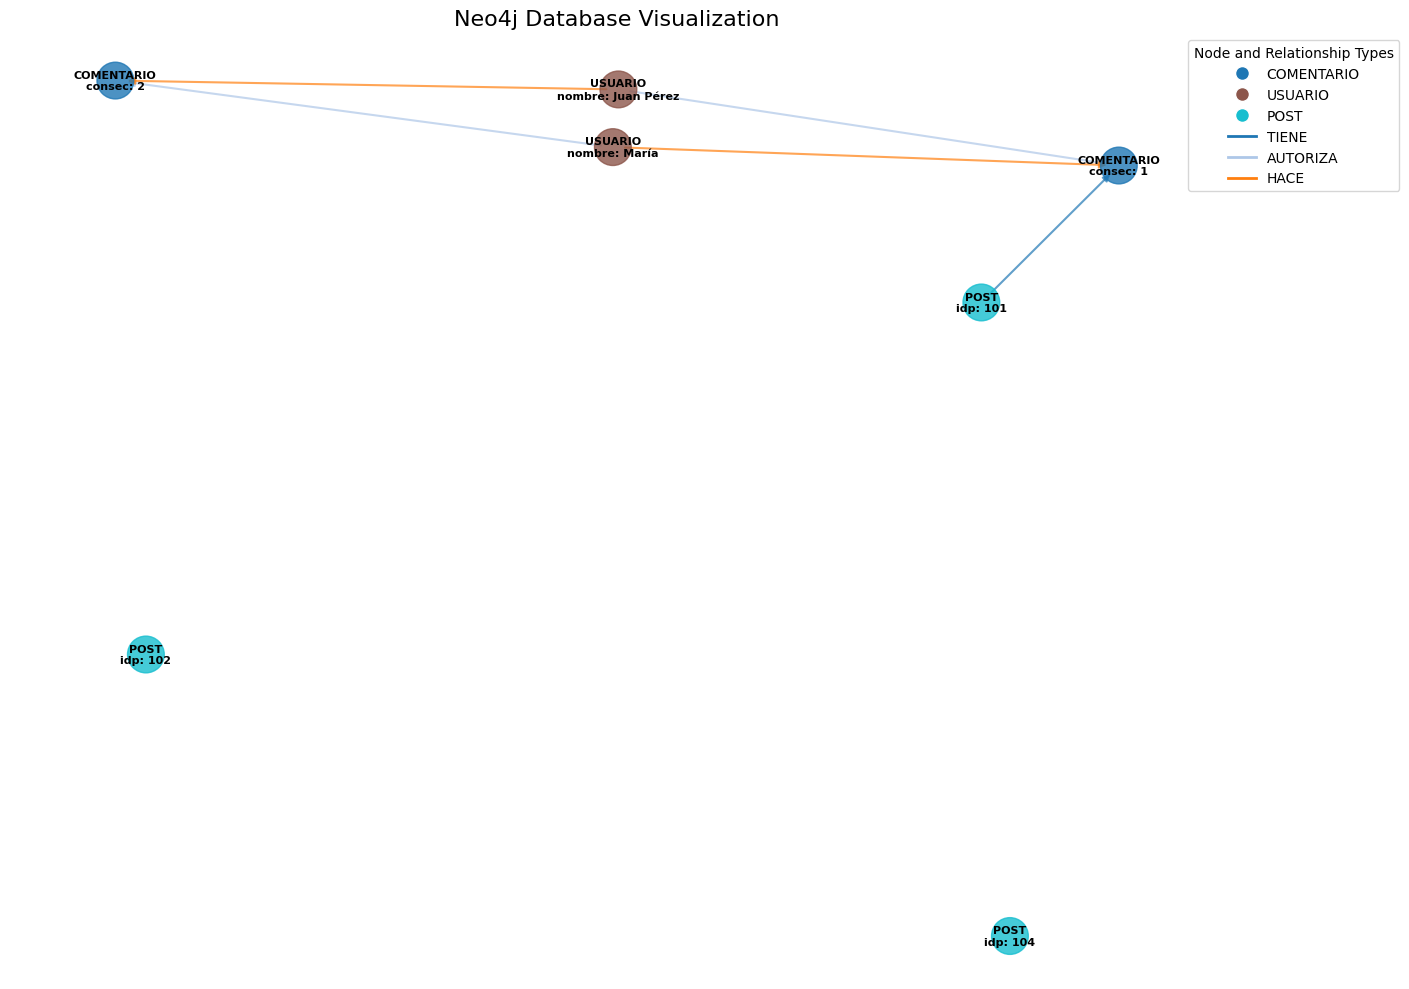

Graph visualization created with 7 nodes and 5 relationships
Image saved as neo4j_database_visualization.png


In [15]:

def visualize_database():
    driver = GraphDatabase.driver(URI, auth=AUTH)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    try:
        with driver.session() as session:
            # Get all nodes - using elementId() instead of deprecated id()
            result_nodes = session.run("""
                MATCH (n)
                RETURN DISTINCT labels(n) AS labels, elementId(n) AS id, properties(n) AS props
            """)
            
            # Process nodes
            nodes_info = {}
            node_types = set()
            for record in result_nodes:
                node_id = record["id"]
                labels = record["labels"][0] if record["labels"] else "Unknown"
                props = record["props"]
                
                # Store key property to display as node label
                label_text = ""
                for key in ['nombre', 'idu', 'idp', 'consec', 'contenido', 'contenidoCom']:
                    if key in props:
                        label_text = f"{labels}\n{key}: {props[key]}"
                        break
                if not label_text:
                    label_text = labels
                
                nodes_info[node_id] = {
                    "label": label_text,
                    "type": labels
                }
                node_types.add(labels)
                
                # Add node to graph
                G.add_node(node_id, label=label_text, node_type=labels)
            
            # Get all relationships - using elementId() instead of deprecated id()
            result_rels = session.run("""
                MATCH (a)-[r]->(b)
                RETURN elementId(a) AS source, elementId(b) AS target, type(r) AS type
            """)
            
            # Process relationships
            edge_types = set()
            for record in result_rels:
                source = record["source"]
                target = record["target"]
                rel_type = record["type"]
                
                G.add_edge(source, target, label=rel_type)
                edge_types.add(rel_type)
    
    finally:
        driver.close()
    
    if len(G) == 0:
        print("No data found in the database or connection failed.")
        print("Let's try a test query to see if the database is reachable...")
        
        try:
            driver = GraphDatabase.driver(URI, auth=AUTH)
            with driver.session() as session:
                # Simple test query
                result = session.run("MATCH (n) RETURN count(n) as count")
                count = result.single()["count"]
                print(f"Database is reachable. Found {count} nodes in total.")
                if count == 0:
                    print("Database is empty. You need to create some data first.")
                else:
                    print("There may be an issue with the query. Check if node labels or property names match your database.")
        except Exception as e:
            print(f"Error connecting to database: {str(e)}")
        finally:
            driver.close()
            
        return
    
    # Create a figure with a title
    plt.figure(figsize=(14, 10))
    plt.title("Neo4j Database Visualization", fontsize=16)
    
    # Create position layout for nodes
    pos = nx.spring_layout(G, seed=42, k=0.5)
    
    # Create color map for different node types
    node_type_list = list(node_types)
    node_colormap = plt.cm.get_cmap('tab10', len(node_type_list))
    node_colors = [node_colormap(node_type_list.index(G.nodes[n]['node_type'])) for n in G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, alpha=0.8)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels={n: G.nodes[n]['label'] for n in G.nodes()}, 
                           font_size=8, font_weight='bold')
    
    # Draw edges with different colors for different relationship types
    edge_type_list = list(edge_types)
    for i, edge_type in enumerate(edge_type_list):
        edge_color = plt.cm.tab20(i)
        edges = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == edge_type]
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, 
                              alpha=0.7, edge_color=[edge_color] * len(edges))
    
    # Create legend for node types
    node_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=node_colormap(i), markersize=10, label=nt)
                  for i, nt in enumerate(node_type_list)]
    
    # Create legend for edge types
    edge_handles = [plt.Line2D([0], [0], color=plt.cm.tab20(i), label=et, lw=2)
                   for i, et in enumerate(edge_type_list)]
    
    # Add legends
    plt.legend(handles=node_handles + edge_handles, 
              title="Node and Relationship Types",
              loc="upper right", bbox_to_anchor=(1.15, 1.0))
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("neo4j_database_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Graph visualization created with {len(G.nodes())} nodes and {len(G.edges())} relationships")
    print(f"Image saved as neo4j_database_visualization.png")

if __name__ == "__main__":
    visualize_database()
    driver.close()

C:\Users\labsy\AppData\Local\Temp\ipykernel_28236\2934072906.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  node_colormap = plt.cm.get_cmap('tab10', len(node_type_list))


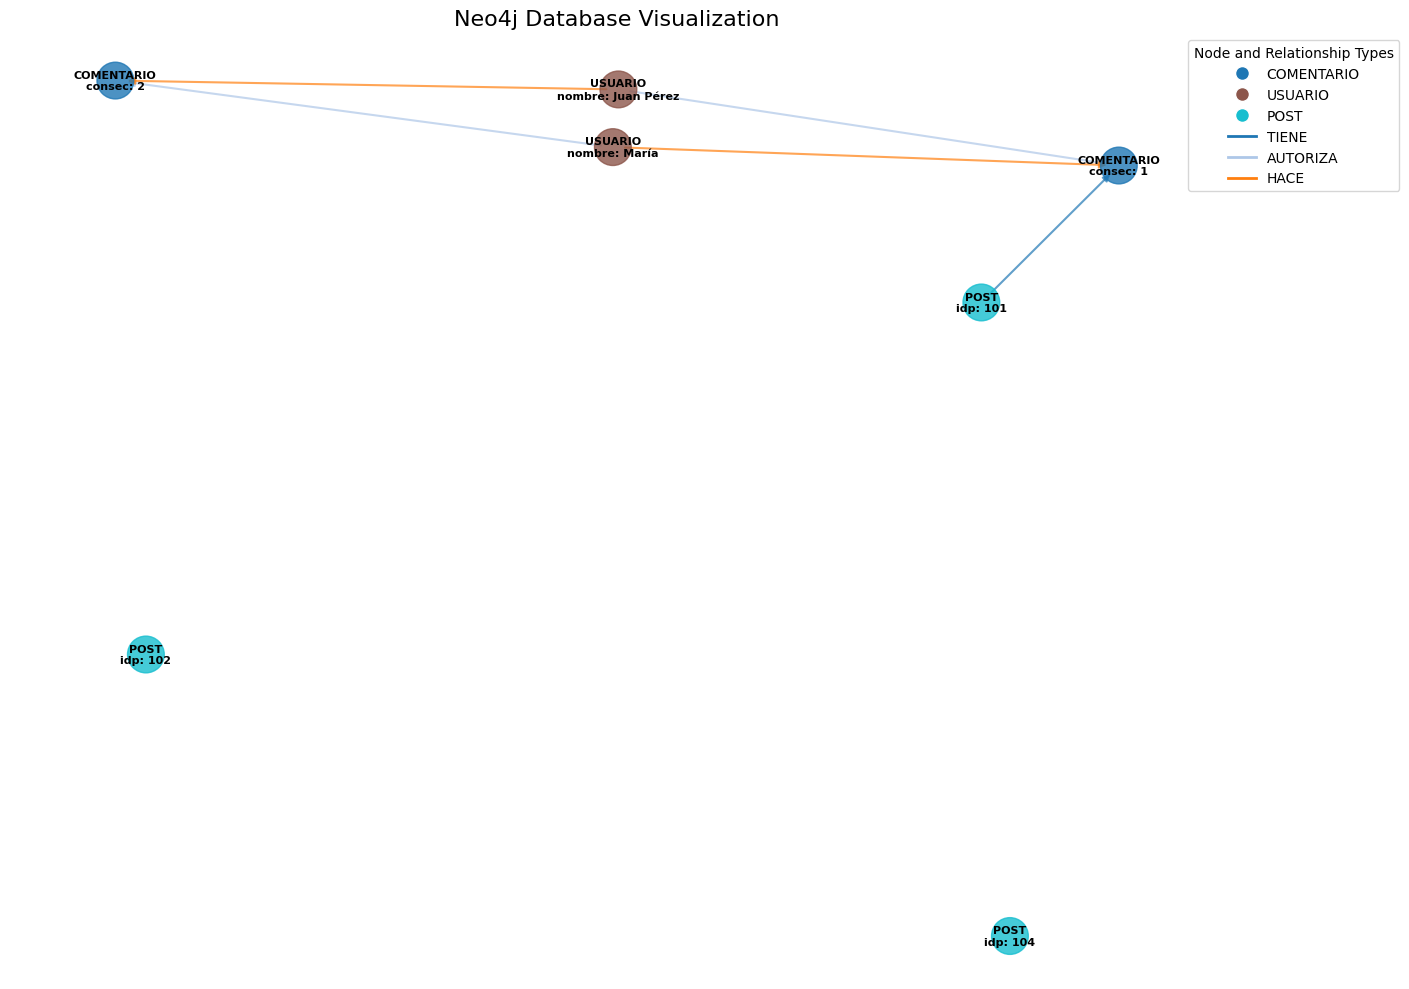

Graph visualization created with 7 nodes and 5 relationships
Image saved as neo4j_database_visualization.png


In [14]:
driver = GraphDatabase.driver(URI, auth=AUTH)
crear_nodo(type = 'post', parametros = {"idp": 102, "contenido": "Hola a todos"})
crear_nodo(type = 'post', parametros = {"idp": 104, "contenido": "Hola a todos"})
visualize_database()
driver.close()